In [164]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quantum Convolutional Processing of the Dataset

This notebook contains all the rutines to apply quantum convolution to an entire dataset. The script will:

1. Load the dataset and print some statistics
2. Create a quantum cicuit
3. Define a quantum convolutional layer
4. Apply the quantum convolutional layer to the entire dataset and save a new version of the dataset

In [177]:
from layers.QConv2D import QConv2D
from circuits.random import ry_random
from utils.plotter import *
from utils import test_loader
from data.datahandler import datahandler
from data.datareader import datareader

import matplotlib.pyplot as plt
import pennylane as qml
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

## Load dataset

Instructions
1. the dataset should be placed in the working directory, specifically in the **datasets** folder.
2. the dataset should be already divided into classes, one-subfolder for earch classes. The folder/class name will be used to encode the label

```
QuantumCNN
│   README.md
│   requirements.txt    
│
└───circuits
└───...
└───datasets
    └───EuroSAT
        └───Highway
                highway1.jpg
                highway2.jpg                
        └─── ....
        └───Lake
                lake1.jpg
                lake2.jpg                

```

Given *the dataset_name*, that must be the same of the folder, the **datahandler** will take care of loading the paths of the images and collected them into a class dictionary. After a report of the dataset will be printed.

In [184]:
dataset_name = 'EuroSAT'
root = os.path.join('datasets', dataset_name)
dhandler = datahandler(root)
dhandler.print_report(name=dataset_name)

Dataset EuroSAT

Class 0 - Forest                    - #images: 3000
Class 1 - River                     - #images: 2500
Class 2 - Highway                   - #images: 2500
Class 3 - AnnualCrop                - #images: 3000
Class 4 - SeaLake                   - #images: 3000
Class 5 - HerbaceousVegetation      - #images: 3000
Class 6 - Industrial                - #images: 2500
Class 7 - Residential               - #images: 3000
Class 8 - PermanentCrop             - #images: 2500
Class 9 - Pasture                   - #images: 2000


The **unpack** function trasforms the dataset from a dictionary to an array. It assigns also the label to each image and returns a dictionary mapping the labels with the class name

In [168]:
labels_mapper, x, y = dhandler.unpack(dhandler.paths)

print('Labels')
for key in labels_mapper: print('{:<30s}{}'.format(key,labels_mapper[key]))

print('\nDataset Size')
print('{:<30s}{}'.format('Images', len(x)))

print('\nTraining Dataset samples')
print('{:<30s}{}'.format('X Train', x[0]))
print('{:<30s}{}'.format('X Train', y[0]))

Labels
Forest                        [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
River                         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Highway                       [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
AnnualCrop                    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
SeaLake                       [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
HerbaceousVegetation          [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Industrial                    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Residential                   [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
PermanentCrop                 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Pasture                       [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Dataset Size
Images                        27000

Training Dataset samples
X Train                       datasets/EuroSAT/Forest/Forest_864.jpg
X Train                       [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Test the keras-like data loader. In this specific case the *datareader.generatorv2* is tested. It contains all the rutines to load images batch by batch (1 in this case).

Reading Image:   0%|          | 0/27000 [00:00<?, ?it/s]

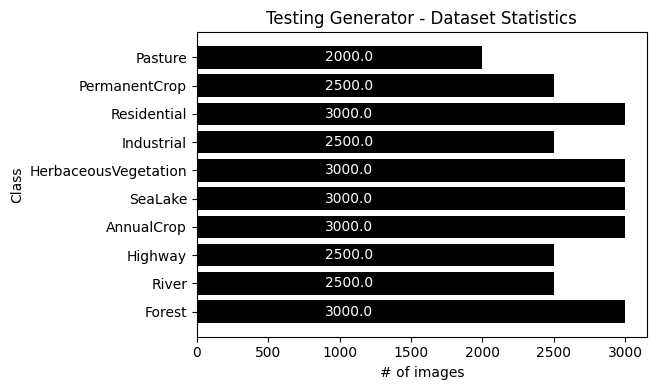

In [196]:
classes = dhandler.paths.keys()
loader  = datareader.generatorv2((x, y), (64,64,3))
test_loader.dlv2([x,y], loader, classes)

## Define Quantum Circuit 

The quantum circuit is used by the quantum convolutional 2D layer. The quantum circuit used in this example has a fixed structure, Ry gates at the beginning, Random Layers U and Z pauli and measurement gates at the end.

```
                                                   _____
                                    |0> ---[Ry]---|     |---[Z]---[m]
                                    |0> ---[Ry]---|     |---[Z]---[m]
                                    |0> ---[Ry]---|  U  |---[Z]---[m]
                                    |0> ---[Ry]---|     |
                                    |0> ..........|_____|
              
```

It is defined by 6 parameters:

1. *QUBITS*: is the number of qubits used, the number is related to the kernel size of convolution. The relation between these two variables is the following:
$$QUBITS \geq KERNEL\_SIZE^2$$

2. *KERNEL_SIZE*: defines the size of the kernel and the number of RY gates
3. *FILTERS*: defines the number of filters produced by the Quantum Convolution
4. *N_LAYERS*: defines the number of U random layers
5. *STRIDE*: defines the stride used for the convolution
6. *NUM_JOBS*: defines the number of workers for Quantum Convolutional parallelization

In [201]:
QUBITS      = 16
KERNEL_SIZE = 3
FILTERS     = 6
N_LAYERS    = 1
STRIDE      = 2
NUM_JOBS    = 8

Create the circuit

In [202]:
circuit = ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS)

Visualize the circuit 

In [203]:
drawer = qml.draw(circuit)
print(drawer(np.random.rand(QUBITS)))

 0: ──RY(0.15)─╭RandomLayers(M0)─┤  <Z>
 1: ──RY(1.27)─├RandomLayers(M0)─┤  <Z>
 2: ──RY(1.34)─├RandomLayers(M0)─┤  <Z>
 3: ──RY(0.24)─├RandomLayers(M0)─┤  <Z>
 4: ──RY(0.68)─├RandomLayers(M0)─┤  <Z>
 5: ──RY(0.79)─├RandomLayers(M0)─┤  <Z>
 6: ──RY(1.68)─├RandomLayers(M0)─┤     
 7: ──RY(1.21)─├RandomLayers(M0)─┤     
 8: ──RY(1.58)─├RandomLayers(M0)─┤     
 9: ───────────├RandomLayers(M0)─┤     
10: ───────────├RandomLayers(M0)─┤     
11: ───────────├RandomLayers(M0)─┤     
12: ───────────├RandomLayers(M0)─┤     
13: ───────────├RandomLayers(M0)─┤     
14: ───────────├RandomLayers(M0)─┤     
15: ───────────╰RandomLayers(M0)─┤     


## Quantum Convolutional 2D layer

The quantum convolutional 2D layer, uses the quantum circuit define above. As for classical convolution a chuck of the input image of kernel_size dimensions is processed by the quantum circuit that then produces the feature maps.
Then as for the classical convolution stride by stride all the chucks of the image are processed.

```
_____________________________________________ Iteration 1 _____________________________________________

                                                                                         Output
                                                                                     ______________
                                                                                    | m3 |    |    |
                                                                                  ______________  _|
        Input Image                                                              | m2 |    |    |  |
    ___________________                                                        ______________  _| _|
   | x1 | x3 |    |    |                                                    __| m1 |    |    |  |  |
   |_|__|_|__|____|____|                                                   |  |____|____|____| _| _|
   | x2 | x4 |    |    |                                                   |  |    |    |    |  |
   |_|__|_|__|____|____|                                                   |  |____|____|____| _|
   | |  | |  |    |    |                                                   |  |    |    |    | 
   |_|__|_|__|____|____|                                                   |  |____|____|____|                     
   | |  | |  |    |    |                                                   | 
   |_|__|_|__|____|____|                                                   | 
     |    |                               Quantum Circuit                  |
     |____|_________________________                            ___________|
                                    |         _____            |
                           |0> ---[Ry(x1)]---|     |---[Z]---[m1]
                           |0> ---[Ry(x2)]---|     |---[Z]---[m2]
                           |0> ---[Ry(x3)]---|  U  |---[Z]---[m3]
                           |0> ---[Ry(x4)]---|_____|


_____________________________________________ Iteration 2 _____________________________________________

                                                                                         Output
                                                                                     ______________
                                                                                    | m3 | m6 |    |
                                                                                  ______________  _|
        Input Image                                                              | m2 | m5 |    |  |
    ___________________                                                        ______________  _| _|
   |    | x3 | x5 |    |                                                    __| m1 | m4 |    |  |  |
   |____|_|__|_|__|____|                                                   |  |____|____|____| _| _|
   |    | x4 | x6 |    |                                                   |  |    |    |    |  |
   |____|_|__|_|__|____|                                                   |  |____|____|____| _|
   |    | |  | |  |    |                                                   |  |    |    |    | 
   |____|_|__|_|__|____|                                                   |  |____|____|____|                     
   |    | |  | |  |    |                                                   | 
   |____|_|__|_|__|____|                                                   | 
          |    |                          Quantum Circuit                  |
          |____|____________________                            ___________|
                                    |         _____            |
                           |0> ---[Ry(x3)]---|     |---[Z]---[m4]
                           |0> ---[Ry(x4)]---|     |---[Z]---[m5]
                           |0> ---[Ry(x5)]---|  U  |---[Z]---[m6]
                           |0> ---[Ry(x6)]---|_____|
              


```

In [213]:
conv1 = QConv2D(
    ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS),
    FILTERS, 
    KERNEL_SIZE, 
    STRIDE, 
    NUM_JOBS
)

In [214]:
(xi, yi) = next(iter(datareader.generator((x, y), 1, (64,64,3))))
img = xi[0]
out1 = conv1.apply(img, verbose = True)

  0%|          | 0/31 [00:00<?, ?it/s]

In [215]:
print('{:<30s}{}'.format('Image shape', img.shape))
print('{:<30s}{}'.format('QuaConv2D L1 shape', out1.shape))

Image shape                   (64, 64, 3)
QuaConv2D L1 shape            (31, 31, 6)


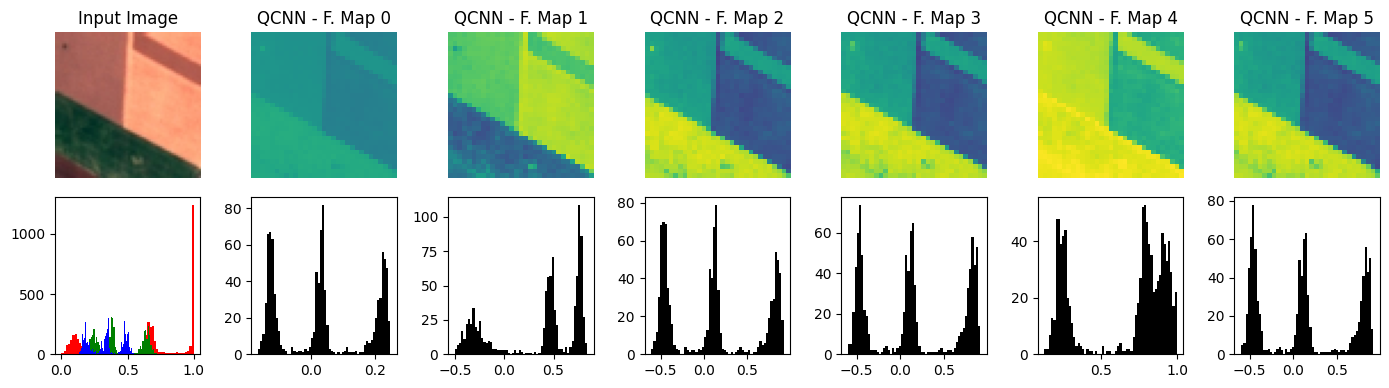

In [216]:
plot_result(img, out1)

## Quantum Preprocessing of the dataset

In [ ]:
# Create folder structures
root2 = root.replace(dataset_name, dataset_name+'_processed')
for path in dhandler.paths.keys():
    os.makedirs(os.path.join(root2, path), exist_ok=True)

In [ ]:
gen = iter(datareader.generatorv2((x, y), (64,64,3)))

for i in tqdm(range(len(x))):
    (xi, yi, pi) = next(gen)
    out1 = conv1.apply(xi, verbose=True)
    pi = pi.replace(dataset_name, dataset_name+'_processed')
    pi = pi.replace('.jpg', '.npy')
    
    with open(pi, 'wb') as f:
        np.save(f, out1)